In [27]:
import pickle 
import os
import pandas as pd
from tqdm import tqdm
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

from d2c.benchmark import D2CWrapper

from d2c.descriptors.loader import DataLoader

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score



In [28]:
# dfs = []
# data_root = './descriptors_cmiknn_full_k3_mbts_MEDIUM_c60_notfull/'
# for testing_file in sorted(os.listdir(data_root)):
#     if testing_file.endswith('.pkl'):
#         df = pd.read_pickle(data_root + testing_file)
#         dfs.append(df)

# descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

In [88]:
data_root = '../data/'


to_dos = []
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01:
            continue

        if max_neighborhood_size != 2:
            continue

        to_dos.append(testing_file)

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]
to_dos_50_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 50]

In [ ]:
## plot the precision recall curve against the threshold
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
# import matplotlib.pyplot as plt

# maxlags = 5
# descriptors_root = './d2c_benchmark/'
# data_root = '../data/'

# td2c_rocs_process = {}
# td2c_precision_process = {}
# td2c_recall_process = {}
# td2c_f1_process = {}

# for testing_file in to_dos_10_variables:
#     print("Working on", testing_file)
#     gen_process_number = int(testing_file.split('_')[0][1:])
#     n_variables = int(testing_file.split('_')[1][1:])
#     max_neighborhood_size = int(testing_file.split('_')[2][2:])
#     noise_std = float(testing_file.split('_')[3][1:-4])


#     training_data = training_set_full.loc[training_set_full['process_id'] != gen_process_number]
#     X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
#     y_train = training_data['is_causal']

#     model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True)

#     model.fit(X_train, y_train)

#     # load original data for truth values
#     dataloader = DataLoader(n_variables = n_variables,
#                 maxlags = maxlags)
#     dataloader.from_pickle(data_root+testing_file)
#     true_causal_dfs = dataloader.get_true_causal_dfs()

#     rocs = {}
#     precisions = {}
#     recalls = {}
#     f1s = {}
#     for i in range(40):
#         #load testing descriptors
#         test_df = pd.read_csv(descriptors_root+testing_file+'_'+str(i)+'.csv', index_col=0)
#         test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort to match the order of the model!

#         X_test = test_df.drop(columns=['graph_id', 'edge_source', 'edge_dest', 'is_causal'])
#         y_test = true_causal_dfs[i]['is_causal']

#         y_pred_proba = model.predict_proba(X_test)[:,1]
#         y_pred = model.predict(X_test)

#         # Step 2: Calculate precision, recall, and thresholds
#         precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

#         # Step 3: Plot the precision-recall curve
#         plt.figure(figsize=(10, 6))
#         plt.plot(thresholds, precision[:-1], label='Precision')
#         plt.plot(thresholds, recall[:-1], label='Recall')
#         plt.xlabel('Threshold')
#         plt.ylabel('Precision/Recall')
#         plt.title('Precision-Recall vs Threshold')
#         plt.legend()
#         plt.grid()
#         plt.show()


#         roc = roc_auc_score(y_test, y_pred_proba)
#         precision = precision_score(y_test, y_pred)
#         recall = recall_score(y_test, y_pred)
#         f1 = f1_score(y_test, y_pred)
        
#         rocs[i] = roc
#         precisions[i] = precision
#         recalls[i] = recall
#         f1s[i] = f1
#     break
#     td2c_rocs_process[gen_process_number] = rocs
#     td2c_precision_process[gen_process_number] = precisions
#     td2c_recall_process[gen_process_number] = recalls
#     td2c_f1_process[gen_process_number] = f1s



In [150]:
from sklearn.metrics import roc_auc_score
maxlags = 5
descriptors_root = './d2c_benchmark/'
data_root = '../data/'

training_set_full = []
for testing_file in to_dos_10_variables:
    gen_process_number = int(testing_file.split('_')[0][1:])
    n_variables = int(testing_file.split('_')[1][1:])
    max_neighborhood_size = int(testing_file.split('_')[2][2:])
    noise_std = float(testing_file.split('_')[3][1:-4])

    dataloader = DataLoader(n_variables = n_variables,
                maxlags = maxlags)
    dataloader.from_pickle(data_root+testing_file)
    true_causal_dfs = dataloader.get_true_causal_dfs()

    for i in range(40):

        test_df = pd.read_csv(descriptors_root+testing_file+'_'+str(i)+'.csv', index_col=0)
        test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort to match the order of the model!
        test_df['is_causal'] = true_causal_dfs[i]['is_causal']
        test_df['process_id'] = gen_process_number
        test_df['graph_id'] = i
        test_df['n_variables'] = n_variables
        test_df['max_neighborhood_size'] = max_neighborhood_size
        test_df['noise_std'] = noise_std

        training_set_full.append(test_df)

training_set_full = pd.concat(training_set_full, axis=0).reset_index(drop=True)



In [158]:
sum_cau_m_eff = training_set_full[['cau_m_eff_q0',
       'cau_m_eff_q1', 'cau_m_eff_q2', 'cau_m_eff_q3', 'cau_m_eff_q4',
       'cau_m_eff_q5', 'cau_m_eff_q6']].sum(axis=1)

sum_eff_m_cau = training_set_full[['eff_m_cau_q0', 'eff_m_cau_q1',
       'eff_m_cau_q2', 'eff_m_cau_q3', 'eff_m_cau_q4', 'eff_m_cau_q5',
       'eff_m_cau_q6']].sum(axis=1)

temp_concat = pd.concat([sum_cau_m_eff, sum_eff_m_cau, training_set_full['is_causal']], axis=1)
temp_concat.loc[temp_concat['is_causal'] == 1]

# 10 fold cv on temp concat 
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X = temp_concat.drop(columns=['is_causal'])
y = temp_concat['is_causal']

skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
roc_aucs = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None)

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_aucs.append(roc_auc)

print(np.mean(roc_aucs), np.std(roc_aucs))

 

0.7646510732288836 0.007010807141718218


In [121]:
td2c_rocs_process = {}
td2c_precision_process = {}
td2c_recall_process = {}
td2c_f1_process = {}


for testing_file in to_dos_10_variables:
    print("Working on", testing_file)
    gen_process_number = int(testing_file.split('_')[0][1:])
    n_variables = int(testing_file.split('_')[1][1:])
    max_neighborhood_size = int(testing_file.split('_')[2][2:])
    noise_std = float(testing_file.split('_')[3][1:-4])


    training_data = training_set_full.loc[training_set_full['process_id'] != gen_process_number]
    X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
    y_train = training_data['is_causal']

    model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True)
    # model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None)

    model.fit(X_train, y_train)

    # load original data for truth values
    dataloader = DataLoader(n_variables = n_variables,
                maxlags = maxlags)
    dataloader.from_pickle(data_root+testing_file)
    true_causal_dfs = dataloader.get_true_causal_dfs()

    rocs = {}
    precisions = {}
    recalls = {}
    f1s = {}
    for i in range(40):
        #load testing descriptors
        test_df = pd.read_csv(descriptors_root+testing_file+'_'+str(i)+'.csv', index_col=0)
        test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort to match the order of the model!

        X_test = test_df.drop(columns=['graph_id', 'edge_source', 'edge_dest', 'is_causal'])
        y_test = true_causal_dfs[i]['is_causal']

        y_pred_proba = model.predict_proba(X_test)[:,1]
        y_pred = y_pred_proba > 0.8

        roc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        rocs[i] = roc
        precisions[i] = precision
        recalls[i] = recall
        f1s[i] = f1

    td2c_rocs_process[gen_process_number] = rocs
    td2c_precision_process[gen_process_number] = precisions
    td2c_recall_process[gen_process_number] = recalls
    td2c_f1_process[gen_process_number] = f1s



Working on P10_N10_Nj2_n0.01.pkl
Working on P11_N10_Nj2_n0.01.pkl
Working on P12_N10_Nj2_n0.01.pkl
Working on P13_N10_Nj2_n0.01.pkl
Working on P14_N10_Nj2_n0.01.pkl
Working on P15_N10_Nj2_n0.01.pkl
Working on P16_N10_Nj2_n0.01.pkl
Working on P18_N10_Nj2_n0.01.pkl
Working on P19_N10_Nj2_n0.01.pkl
Working on P1_N10_Nj2_n0.01.pkl
Working on P20_N10_Nj2_n0.01.pkl
Working on P2_N10_Nj2_n0.01.pkl
Working on P3_N10_Nj2_n0.01.pkl
Working on P4_N10_Nj2_n0.01.pkl
Working on P6_N10_Nj2_n0.01.pkl
Working on P7_N10_Nj2_n0.01.pkl
Working on P8_N10_Nj2_n0.01.pkl
Working on P9_N10_Nj2_n0.01.pkl


In [122]:
mix_td2c = pd.concat([pd.DataFrame(td2c_rocs_process).mean(),pd.DataFrame(td2c_precision_process).mean(),pd.DataFrame(td2c_recall_process).mean(),pd.DataFrame(td2c_f1_process).mean()],axis=1)
mix_td2c.columns = ['roc','precision','recall','f1']
#index name 'generative process'
mix_td2c.index.name = 'generative process'
mix_td2c

,roc,precision,recall,f1
generative process,,,,
10,0.916038,0.877221,0.677664,0.759592
11,0.968186,0.794425,0.778127,0.778880
12,0.998913,0.717162,0.995172,0.830507
13,0.834544,0.985306,0.375870,0.542816
14,0.985434,0.816025,0.719995,0.759502
15,0.999938,0.970381,0.993291,0.981379
16,0.922359,0.726142,0.675827,0.692048
18,0.999956,0.971718,0.993529,0.981928
19,0.926665,0.395622,0.290069,0.330141


In [116]:
mix_pcmci = pd.concat([pd.DataFrame(pcmci_rocs_process).mean(),pd.DataFrame(pcmci_precision_process).mean(),pd.DataFrame(pcmci_recall_process).mean(),pd.DataFrame(pcmci_f1_process).mean()],axis=1)
mix_pcmci.columns = ['roc','precision','recall','f1']
#index name 'generative process'
mix_pcmci.index.name = 'generative process'
mix_pcmci

,roc,precision,recall,f1
generative process,,,,
10,0.500712,0.034849,0.059787,0.043654
11,0.970245,0.358982,0.878883,0.507742
12,0.814148,0.161756,0.754577,0.264908
13,0.731120,0.359127,0.447729,0.396074
14,0.994002,0.385567,0.969392,0.549880
15,1.000000,0.393064,1.000000,0.562477
16,0.504760,0.029725,0.063912,0.040278
18,1.000000,0.393064,1.000000,0.562477
19,0.985096,0.552790,0.940681,0.695015


# PCMCI

In [115]:
#Let's run PCMCI on these ones 
from d2c.benchmark import PCMCI


pcmci_rocs_process = {}
pcmci_precision_process = {}
pcmci_recall_process = {}
pcmci_f1_process = {}

for testing_file in to_dos_10_variables:
        print("Working on", testing_file)
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # load original data for truth values
        dataloader = DataLoader(n_variables = n_variables,
                        maxlags = maxlags)
        dataloader.from_pickle(data_root+testing_file)
        observations = dataloader.get_original_observations()
        true_causal_dfs = dataloader.get_true_causal_dfs()


        pcmci = PCMCI(ts_list=observations, maxlags=maxlags, n_jobs=40)
        pcmci.run()
        causal_dfs_pcmci = pcmci.get_causal_dfs()
        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for i in range(40):

                y_pred = causal_dfs_pcmci[i]['is_causal'].astype(int)
                y_pred_proba = 1 - causal_dfs_pcmci[i]['p_value']
                y_test = true_causal_dfs[i]['is_causal'].astype(int)

                roc = roc_auc_score(y_test, y_pred_proba)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                
                rocs[i] = roc
                precisions[i] = precision
                recalls[i] = recall
                f1s[i] = f1

        pcmci_rocs_process[gen_process_number] = rocs
        pcmci_precision_process[gen_process_number] = precisions
        pcmci_recall_process[gen_process_number] = recalls
        pcmci_f1_process[gen_process_number] = f1s



Working on P10_N10_Nj2_n0.01.pkl
Working on P11_N10_Nj2_n0.01.pkl
Working on P12_N10_Nj2_n0.01.pkl
Working on P13_N10_Nj2_n0.01.pkl
Working on P14_N10_Nj2_n0.01.pkl
Working on P15_N10_Nj2_n0.01.pkl
Working on P16_N10_Nj2_n0.01.pkl
Working on P18_N10_Nj2_n0.01.pkl
Working on P19_N10_Nj2_n0.01.pkl
Working on P1_N10_Nj2_n0.01.pkl
Working on P20_N10_Nj2_n0.01.pkl
Working on P2_N10_Nj2_n0.01.pkl
Working on P3_N10_Nj2_n0.01.pkl
Working on P4_N10_Nj2_n0.01.pkl
Working on P6_N10_Nj2_n0.01.pkl
Working on P7_N10_Nj2_n0.01.pkl
Working on P8_N10_Nj2_n0.01.pkl
Working on P9_N10_Nj2_n0.01.pkl


# Dynotears

In [134]:
#Let's run PCMCI on these ones 
from d2c.benchmark import DYNOTEARS
N_JOBS = 20

dyno_rocs_process = {}
dyno_precision_process = {}
dyno_recall_process = {}
dyno_f1_process = {}

for testing_file in to_dos_10_variables:
        print("Working on", testing_file)
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # load original data for truth values
        dataloader = DataLoader(n_variables = n_variables,
                        maxlags = maxlags)
        dataloader.from_pickle(data_root+testing_file)
        observations = dataloader.get_original_observations()
        true_causal_dfs = dataloader.get_true_causal_dfs()

        dynotears = DYNOTEARS(ts_list=observations, maxlags=maxlags, n_jobs=N_JOBS)
        dynotears.run()
        causal_dfs_dynotears = dynotears.get_causal_dfs()

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for i in range(40):

                y_pred = causal_dfs_dynotears[i]['is_causal'].astype(int)
                y_pred_proba = 1 - causal_dfs_dynotears[i]['p_value']
                y_test = true_causal_dfs[i]['is_causal'].astype(int)

                roc = None
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                
                rocs[i] = roc
                precisions[i] = precision
                recalls[i] = recall
                f1s[i] = f1

        dyno_rocs_process[gen_process_number] = rocs
        dyno_precision_process[gen_process_number] = precisions
        dyno_recall_process[gen_process_number] = recalls
        dyno_f1_process[gen_process_number] = f1s



Working on P10_N10_Nj2_n0.01.pkl
Working on P11_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P12_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P13_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P14_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P15_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P16_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P18_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P19_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P1_N10_Nj2_n0.01.pkl
Working on P20_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P2_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P3_N10_Nj2_n0.01.pkl
Working on P4_N10_Nj2_n0.01.pkl
Working on P6_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P7_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P8_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

Working on P9_N10_Nj2_n0.01.pkl


/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gpaldino/miniconda3/envs/d2cpy/lib/python3.8/s

In [135]:
mix_dyno = pd.concat([pd.DataFrame(dyno_rocs_process).mean(),pd.DataFrame(dyno_precision_process).mean(),pd.DataFrame(dyno_recall_process).mean(),pd.DataFrame(dyno_f1_process).mean()],axis=1)
mix_dyno.columns = ['roc','precision','recall','f1']
#index name 'generative process'
mix_dyno.index.name = 'generative process'
mix_dyno

,roc,precision,recall,f1
generative process,,,,
10,NaN,0.034737,0.526401,0.064315
11,NaN,0.000000,0.000000,0.000000
12,NaN,0.000000,0.000000,0.000000
13,NaN,0.000000,0.000000,0.000000
14,NaN,0.000000,0.000000,0.000000
15,NaN,0.000000,0.000000,0.000000
16,NaN,0.000000,0.000000,0.000000
18,NaN,0.000000,0.000000,0.000000
19,NaN,0.134294,0.109025,0.108754


In [140]:
import os

os.environ['MKL_NUM_THREADS'] = '1'  # Limit to 4 threads
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'  # Limit to 4 threads
os.environ['OMP_NUM_THREADS'] = '1'

def complete_causal_df(causal_df, n_variables, maxlags):
    causal_df = causal_df.copy()
    all_pairs = [(from_, to) for from_ in range(n_variables,n_variables * (maxlags + 1)) for to in range(n_variables)]
    
    existing_pairs = set(zip(causal_df['from'], causal_df['to']))
    missing_pairs = [(from_, to) for from_, to in all_pairs if (from_, to) not in existing_pairs]
    
    # Create all missing rows at once if there are any missing pairs
    if missing_pairs:
        missing_rows = pd.DataFrame(missing_pairs, columns=['from', 'to'])
        missing_rows['effect'] = 0.0
        missing_rows['p-value'] = None
        missing_rows['probability'] = 0.0
        missing_rows['is_causal'] = False
        causal_df = pd.concat([causal_df, missing_rows], ignore_index=True)
    
    return causal_df.sort_values(by=['from', 'to']).reset_index(drop=True)

from d2c.benchmark import VARLiNGAM
N_JOBS = 20

varlingam_rocs_process = {}
varlingam_precision_process = {}
varlingam_recall_process = {}
varlingam_f1_process = {}

for testing_file in to_dos_10_variables:
        print("Working on", testing_file)
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # load original data for truth values
        dataloader = DataLoader(n_variables = n_variables,
                        maxlags = maxlags)
        dataloader.from_pickle(data_root+testing_file)
        observations = dataloader.get_original_observations()
        true_causal_dfs = dataloader.get_true_causal_dfs()

        varlingam = VARLiNGAM(ts_list=observations, maxlags=maxlags, n_jobs=N_JOBS)
        varlingam.run()
        causal_dfs_varlingam = varlingam.get_causal_dfs()

        causal_dfs_varlingam = [complete_causal_df(causal_df, n_variables,maxlags) for causal_df in causal_dfs_varlingam.values()]

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for i in range(40):

                y_pred = causal_dfs_varlingam[i]['is_causal'].astype(int)
                y_pred_proba = causal_dfs_varlingam[i]['probability']
                y_test = true_causal_dfs[i]['is_causal'].astype(int)

                roc = roc_auc_score(y_test, y_pred_proba)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                
                rocs[i] = roc
                precisions[i] = precision
                recalls[i] = recall
                f1s[i] = f1

        varlingam_rocs_process[gen_process_number] = rocs
        varlingam_precision_process[gen_process_number] = precisions
        varlingam_recall_process[gen_process_number] = recalls
        varlingam_f1_process[gen_process_number] = f1s



Working on P10_N10_Nj2_n0.01.pkl
Working on P11_N10_Nj2_n0.01.pkl
Working on P12_N10_Nj2_n0.01.pkl
Working on P13_N10_Nj2_n0.01.pkl
Working on P14_N10_Nj2_n0.01.pkl
Working on P15_N10_Nj2_n0.01.pkl
Working on P16_N10_Nj2_n0.01.pkl
Working on P18_N10_Nj2_n0.01.pkl
Working on P19_N10_Nj2_n0.01.pkl
Working on P1_N10_Nj2_n0.01.pkl
Working on P20_N10_Nj2_n0.01.pkl
Working on P2_N10_Nj2_n0.01.pkl
Working on P3_N10_Nj2_n0.01.pkl
Working on P4_N10_Nj2_n0.01.pkl
Working on P6_N10_Nj2_n0.01.pkl
Working on P7_N10_Nj2_n0.01.pkl
Working on P8_N10_Nj2_n0.01.pkl
Working on P9_N10_Nj2_n0.01.pkl


In [145]:
mix_varlingam = pd.concat([pd.DataFrame(varlingam_rocs_process).mean(),pd.DataFrame(varlingam_precision_process).mean(),pd.DataFrame(varlingam_recall_process).mean(),pd.DataFrame(varlingam_f1_process).mean()],axis=1)
mix_varlingam.columns = ['roc','precision','recall','f1']
#index name 'generative process'
mix_varlingam.index.name = 'generative process'
mix_varlingam

,roc,precision,recall,f1
generative process,,,,
10,0.475717,0.025746,0.160424,0.044184
11,0.949388,0.431362,0.782980,0.550050
12,0.705180,0.136511,0.569421,0.218831
13,0.784846,0.513735,0.418617,0.453744
14,0.978179,0.391659,0.906485,0.539849
15,0.959174,0.158908,1.000000,0.273690
16,0.508269,0.019330,0.022013,0.020221
18,0.959174,0.158908,1.000000,0.273690
19,0.962910,0.320143,0.958782,0.471596


In [141]:
# pickle everything
with open('journal_results_N10.pkl', 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process, pcmci_rocs_process, pcmci_precision_process, pcmci_recall_process, pcmci_f1_process, dyno_rocs_process, dyno_precision_process, dyno_recall_process, dyno_f1_process, varlingam_rocs_process, varlingam_precision_process, varlingam_recall_process, varlingam_f1_process)
    pickle.dump(everything, f)

In [3]:
# open
import pickle
with open('journal_results_N10.pkl', 'rb') as f:
    td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process, pcmci_rocs_process, pcmci_precision_process, pcmci_recall_process, pcmci_f1_process, dyno_rocs_process, dyno_precision_process, dyno_recall_process, dyno_f1_process, varlingam_rocs_process, varlingam_precision_process, varlingam_recall_process, varlingam_f1_process = pickle.load(f)

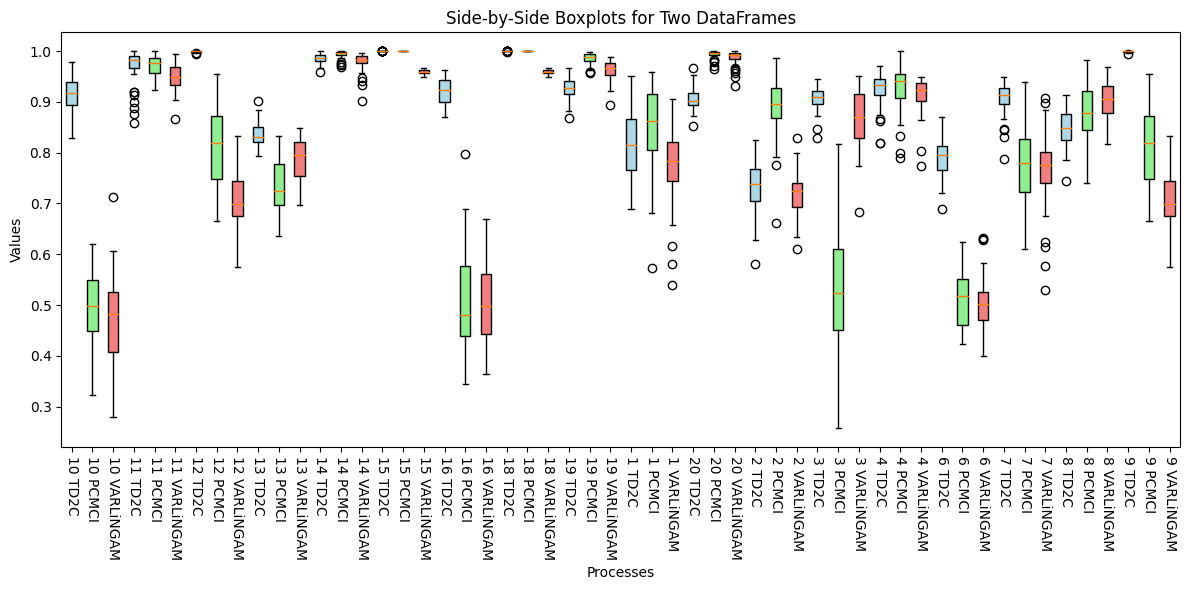

In [148]:
import matplotlib.pyplot as plt

df1 = pd.DataFrame(td2c_rocs_process)
df2 = pd.DataFrame(pcmci_rocs_process)
df3 = pd.DataFrame(varlingam_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C')
    labels.append(f'{col} PCMCI')
    labels.append(f'{col} VARLiNGAM')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for Two DataFrames')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

In [4]:
import matplotlib.pyplot as plt

df1 = pd.DataFrame(td2c_f1_process)
df2 = pd.DataFrame(pcmci_f1_process)
df3 = pd.DataFrame(varlingam_f1_process)
df4 = pd.DataFrame(dyno_f1_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    combined_data.append(df3[col])
    combined_data.append(df4[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} td2c')
    labels.append(f'{col} pcmci')
    labels.append(f'{col} varlingam')
    labels.append(f'{col} dyno')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 4])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots for Two DataFrames')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

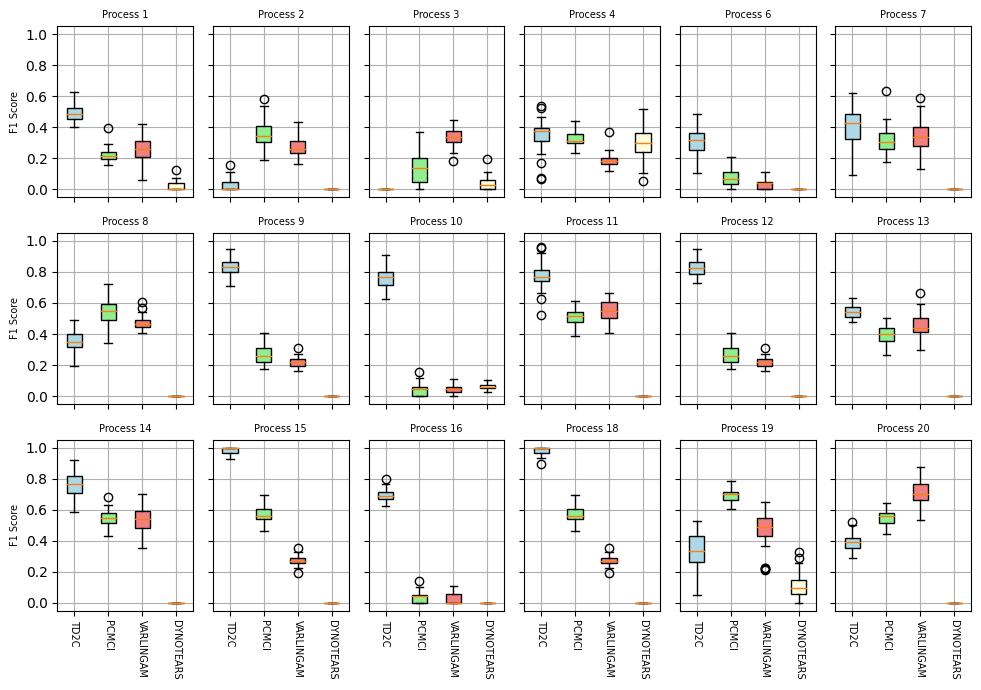

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming td2c_f1_process, pcmci_f1_process, varlingam_f1_process, and dyno_f1_process are defined

df1 = pd.DataFrame(td2c_f1_process)
df2 = pd.DataFrame(pcmci_f1_process)
df3 = pd.DataFrame(varlingam_f1_process)
df4 = pd.DataFrame(dyno_f1_process)

# Number of processes
num_processes = df1.shape[1]
fontsize = 7
# Plotting each process separately in a grid of 6 columns and 3 rows
fig, axes = plt.subplots(3, 6, figsize=(10, 7), sharex=True, sharey=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

for i, col in enumerate([1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]):
    combined_data = [df1[col], df2[col], df3[col], df4[col]]
    labels = [f'TD2C', f'PCMCI', f'VARLINGAM', f'DYNOTEARS']
    
    row, col_idx = divmod(i, 6)
    box = axes[row, col_idx].boxplot(combined_data, patch_artist=True)
    
    for patch, j in zip(box['boxes'], range(len(box['boxes']))):
        patch.set_facecolor(colors[j % 4])
    
    axes[row, col_idx].set_title(f'Process {col}')
    axes[row, col_idx].title.set_fontsize(fontsize)
    axes[row, col_idx].set_xticks(range(1, len(labels) + 1))
    axes[row, col_idx].set_xticklabels(labels, rotation=-90)
    axes[row, col_idx].tick_params(axis='x', labelsize=fontsize)
    if col_idx == 0:
        axes[row, col_idx].set_ylabel('F1 Score')
        axes[row, col_idx].yaxis.label.set_size(fontsize)
    # Add this line:
    axes[row, col_idx].grid(True)


# Remove any empty subplots if the number of processes is less than 18
if num_processes < 18:
    for i in range(num_processes, 18):
        row, col_idx = divmod(i, 6)
        fig.delaxes(axes[row, col_idx])


plt.tight_layout()
plt.savefig('f1_scores_N10.pdf', format='pdf')

plt.show()

#make vector image pdf


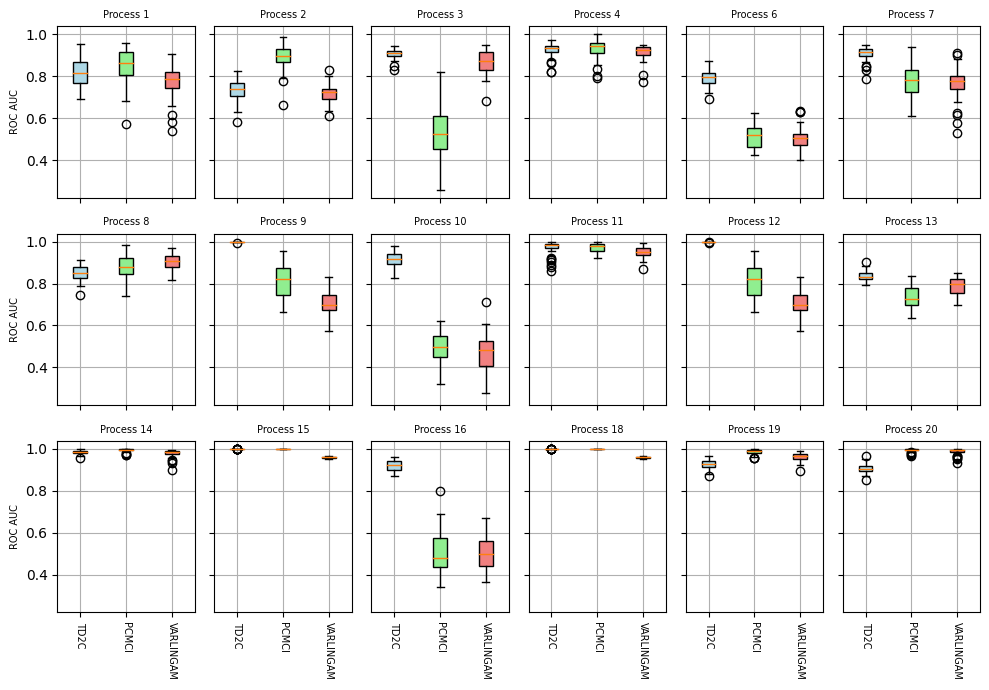

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming td2c_f1_process, pcmci_f1_process, varlingam_f1_process, and dyno_f1_process are defined

df1 = pd.DataFrame(td2c_rocs_process)
df2 = pd.DataFrame(pcmci_rocs_process)
df3 = pd.DataFrame(varlingam_rocs_process)

# Number of processes
num_processes = df1.shape[1]
fontsize = 7
# Plotting each process separately in a grid of 6 columns and 3 rows
fig, axes = plt.subplots(3, 6, figsize=(10, 7), sharex=True, sharey=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

for i, col in enumerate([1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]):
    combined_data = [df1[col], df2[col], df3[col]]
    labels = [f'TD2C', f'PCMCI', f'VARLINGAM']
    
    row, col_idx = divmod(i, 6)
    box = axes[row, col_idx].boxplot(combined_data, patch_artist=True)
    
    for patch, j in zip(box['boxes'], range(len(box['boxes']))):
        patch.set_facecolor(colors[j % 3])
    
    axes[row, col_idx].set_title(f'Process {col}')
    axes[row, col_idx].title.set_fontsize(fontsize)
    axes[row, col_idx].set_xticks(range(1, len(labels) + 1))
    axes[row, col_idx].set_xticklabels(labels, rotation=-90)
    axes[row, col_idx].tick_params(axis='x', labelsize=fontsize)
    if col_idx == 0:
        axes[row, col_idx].set_ylabel('ROC AUC')
        axes[row, col_idx].yaxis.label.set_size(fontsize)
    # Add this line:
    axes[row, col_idx].grid(True)


# Remove any empty subplots if the number of processes is less than 18
if num_processes < 18:
    for i in range(num_processes, 18):
        row, col_idx = divmod(i, 6)
        fig.delaxes(axes[row, col_idx])


plt.tight_layout()
plt.savefig('roc_scores_N10.pdf', format='pdf')

plt.show()

#make vector image pdf


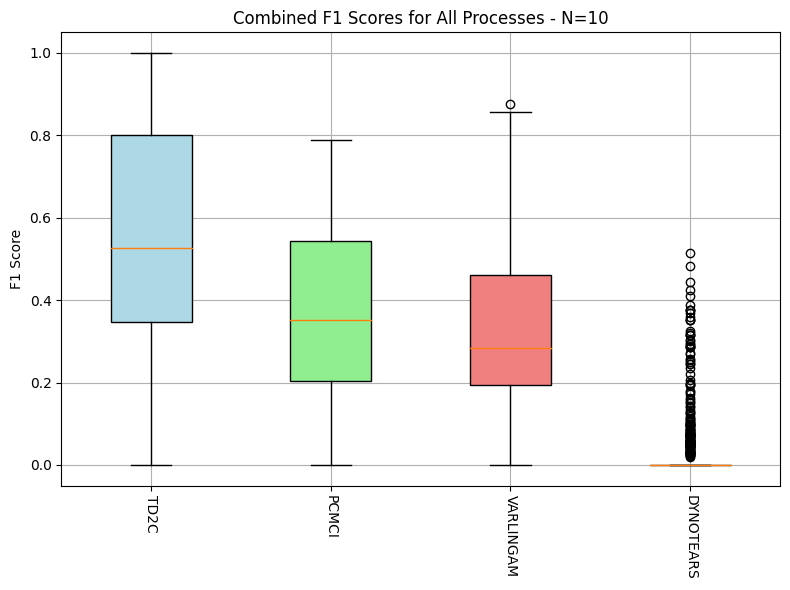

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming td2c_f1_process, pcmci_f1_process, varlingam_f1_process, and dyno_f1_process are defined

df1 = pd.DataFrame(td2c_f1_process)
df2 = pd.DataFrame(pcmci_f1_process)
df3 = pd.DataFrame(varlingam_f1_process)
df4 = pd.DataFrame(dyno_f1_process)

# Concatenate the data for each method across all processes
combined_td2c = pd.concat([df1[col] for col in df1.columns], ignore_index=True)
combined_pcmci = pd.concat([df2[col] for col in df2.columns], ignore_index=True)
combined_varlingam = pd.concat([df3[col] for col in df3.columns], ignore_index=True)
combined_dyno = pd.concat([df4[col] for col in df4.columns], ignore_index=True)

# Combine all methods into one DataFrame for plotting
combined_data = [combined_td2c, combined_pcmci, combined_varlingam, combined_dyno]
labels = ['TD2C', 'PCMCI', 'VARLINGAM', 'DYNOTEARS']

# Create a single boxplot
fig, ax = plt.subplots(figsize=(8, 6))
box = ax.boxplot(combined_data, patch_artist=True)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=-90, fontsize=10)
ax.set_ylabel('F1 Score', fontsize=10)
ax.set_title('Combined F1 Scores for All Processes - N=10', fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.savefig('combined_f1_scores_N10.pdf', format='pdf')

plt.show()


In [ ]:

from sklearn.metrics import roc_auc_score

rocs_process = {}
for process in descriptors_training['process_id'].unique():

    training_data = descriptors_training.loc[descriptors_training['process_id'] != process]
    X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
    y_train = training_data['is_causal']

    model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50)

    model.fit(X_train, y_train)

    rocs = {}
    for i in range(40):
        test_df = pd.read_csv(f'./d2c_benchmark/P{process}_N5_Nj2_n0.01.pkl'+'_'+str(i)+'.csv', index_col=0)
        test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True)

        X_test = test_df.drop(columns=['graph_id', 'edge_source', 'edge_dest', 'is_causal'])
        y_test = true_causal_dfs[i]['is_causal']


        y_pred = model.predict_proba(X_test)[:,1]

        roc = roc_auc_score(y_test, y_pred)

        rocs[i] = roc

    rocs_process[process] = rocs




In [6]:
data_root = '../../data/new_data/'
destination_root = './'
destination = 'd2c_all_couples_MB5_full'
if not os.path.exists(destination_root+'/'+destination):
    os.makedirs(destination_root+'/'+destination)
maxlags = 5
# empty folder ../../data/new_benchmark/
for todo in [to_dos_10_variables]:
    for testing_file in tqdm(todo):
        if testing_file.endswith('.pkl'):
            gen_process_number = int(testing_file.split('_')[0][1:])
            n_variables = int(testing_file.split('_')[1][1:])
            max_neighborhood_size = int(testing_file.split('_')[2][2:])
            noise_std = float(testing_file.split('_')[3][1:-4])
                
            filename = f'{destination_root}/{destination}/P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'

            training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
            X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_train = training_data['is_causal']

            model = BalancedRandomForestClassifier(n_estimators=50, random_state=0, n_jobs=1, replacement=True, sampling_strategy='all')

            model.fit(X_train, y_train)

            dataloader = DataLoader(n_variables = n_variables,
                            maxlags = maxlags)
            dataloader.from_pickle(data_root+testing_file)
            observations = dataloader.get_original_observations()
            true_causal_dfs = dataloader.get_true_causal_dfs()

            d2cwrapper = D2CWrapper(ts_list=observations, n_variables=n_variables, model=model, maxlags=maxlags, n_jobs = 55, full=True)

            d2cwrapper.run()

            causal_df = d2cwrapper.get_causal_dfs()

            with open(filename, 'wb') as f:
                    pickle.dump((
                                causal_df, 
                                true_causal_dfs), f)     
    

100%|██████████| 19/19 [11:07:54<00:00, 2109.20s/it] 


25 vars

In [7]:
data_root = '../../data/new_data/'
destination_root = '../../data/new_benchmark'
destination = 'd2c_all_couples_MB5_full'

if not os.path.exists(destination_root+'/'+destination):
    os.makedirs(destination_root+'/'+destination)
maxlags = 5
# empty folder ../../data/new_benchmark/

for todo in [to_dos_25_variables]:
    for testing_file in tqdm(todo):
        if testing_file.endswith('.pkl'):
            gen_process_number = int(testing_file.split('_')[0][1:])
            n_variables = int(testing_file.split('_')[1][1:])
            max_neighborhood_size = int(testing_file.split('_')[2][2:])
            noise_std = float(testing_file.split('_')[3][1:-4])
                
            filename = f'{destination_root}/{destination}/P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'

            training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
            X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_train = training_data['is_causal']

            model = BalancedRandomForestClassifier(n_estimators=50, random_state=0, n_jobs=1, replacement=True, sampling_strategy='all')

            model.fit(X_train, y_train)

            dataloader = DataLoader(n_variables = n_variables,
                            maxlags = maxlags)
            dataloader.from_pickle(data_root+testing_file)
            observations = dataloader.get_original_observations()
            true_causal_dfs = dataloader.get_true_causal_dfs()


            d2cwrapper = D2CWrapper(ts_list=observations, n_variables=n_variables, model=model, maxlags=maxlags, n_jobs = 55, full=True)

            d2cwrapper.run()

            causal_df = d2cwrapper.get_causal_dfs()

            with open(filename, 'wb') as f:
                    pickle.dump((
                                causal_df, 
                                true_causal_dfs), f)     
    

 74%|███████▎  | 14/19 [15:35:46<5:45:07, 4141.58s/it]

In [6]:
# handle the two missing files separately
missing_files = ['P8_N25_Nj8_n0.005.pkl','P9_N25_Nj8_n0.005.pkl']

data_root = '../../data/new_data/'
destination_root = '../../data/new_benchmark'
destination = 'd2c_all_couples_MB5_full'

maxlags = 5
# empty folder ../../data/new_benchmark/


for testing_file in tqdm(missing_files):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
            
        filename = f'{destination_root}/{destination}/P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'

        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        model = BalancedRandomForestClassifier(n_estimators=50, random_state=0, n_jobs=1, replacement=True, sampling_strategy='all')

        model.fit(X_train, y_train)

        dataloader = DataLoader(n_variables = n_variables,
                        maxlags = maxlags)
        dataloader.from_pickle(data_root+testing_file)
        observations = dataloader.get_original_observations()
        true_causal_dfs = dataloader.get_true_causal_dfs()


        d2cwrapper = D2CWrapper(ts_list=observations, n_variables=n_variables, model=model, maxlags=maxlags, n_jobs = 55, full=True)

        d2cwrapper.run()

        causal_df = d2cwrapper.get_causal_dfs()

        with open(filename, 'wb') as f:
                pickle.dump((
                            causal_df, 
                            true_causal_dfs), f)     
    

100%|██████████| 2/2 [2:07:35<00:00, 3827.78s/it]  


50 variables is just too much

In [7]:
# root = '../../data/new_data/'
# destination_root = '../../data/new_benchmark'
# destination = 'd2c_all_couples_MB5_full'

# if not os.path.exists(destination_root+'/'+destination):
#     os.makedirs(destination_root+'/'+destination)
# maxlags = 5
# # empty folder ../../data/new_benchmark/

# for todo in [to_dos_50_variables]:
#     for file in tqdm(todo):
#         if file.endswith('.pkl'):
#             gen_process_number = int(file.split('_')[0][1:])
#             n_variables = int(file.split('_')[1][1:])
#             max_neighborhood_size = int(file.split('_')[2][2:])
#             noise_std = float(file.split('_')[3][1:-4])
                
#             filename = f'{destination_root}/{destination}/P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'

#             training_data = data.loc[data['process_id'] != gen_process_number]
#             X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
#             y_train = training_data['is_causal']

#             model = BalancedRandomForestClassifier(n_estimators=50, random_state=0, n_jobs=1, replacement=True, sampling_strategy='all')

#             model.fit(X_train, y_train)

#             dataloader = DataLoader(n_variables = n_variables,
#                             maxlags = maxlags)
#             dataloader.from_pickle(root+file)
#             observations = dataloader.get_original_observations()
#             true_causal_dfs = dataloader.get_true_causal_dfs()


#             d2cwrapper = D2CWrapper(ts_list=observations, n_variables=n_variables, model=model, maxlags=maxlags, n_jobs = 55, full=True)

#             d2cwrapper.run()

#             causal_df = d2cwrapper.get_causal_dfs()

#             with open(filename, 'wb') as f:
#                     pickle.dump((
#                                 causal_df, 
#                                 true_causal_dfs), f)     
    

  0%|          | 0/10 [1:39:35<?, ?it/s]


KeyboardInterrupt: 